### This notebook is used to create the affected area at the level of census tracks and follow similar steps at the "1- L train shapes" notebook and cutting the L line up to th Broadway Junction station

In [1]:
import zipfile 
import pysal as ps
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
import gzip
import mapreduce as mr
import csv
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from time import sleep

#### Get Census Tracks shapes

In [2]:
fname = 'Data/CensusTracks.geojson'
tracts = gpd.GeoDataFrame.from_file(fname)

In [3]:
affectedTracts = tracts[tracts.Within15min == True]

In [4]:
# We can further isolate specific areas (like williamsburg)
# using ntaname (Legacy, we want walking distance)

#affectedTracts = tracts[(tracts.Within15min == True) &
#                       ((tracts.ntaname == 'Williamsburg') |
#                        (tracts.ntaname == 'East Williamsburg'))]

### Get NYC zipcode shapes

In [5]:
SQL_SOURCE = 'https://fernando-melchor.carto.com/api/v2/sql'

In [6]:
# functoin to query CartoDB
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [7]:
# Retreive the NYC map with Zip Codes shapes and store in geodataframe

NYCshapeQuery = '''
SELECT *
FROM nyc_zip_code
'''
NYCshapeStream = queryCartoDB(NYCshapeQuery, format = 'GeoJSON')
NYCshapeData   = json.loads(NYCshapeStream.read())
NYCshape     = gpd.GeoDataFrame.from_features(NYCshapeData['features'])

NYCshape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

### Get subway lines shapefiles

In [8]:
# Load the subway lines geodataframe
subline = gpd.GeoDataFrame.from_file('Subway Lines.geojson')
subline.crs = from_epsg(4326) #= from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

### Get subway stations shapefiles

In [9]:
# Retreive the Subway Stations geodataframe
subStations = gpd.GeoDataFrame.from_file('Subway Stations.geojson')
subStations.crs = from_epsg(4326)

In [10]:
# Filter L train only (line and stations)
lsubline = subline[(subline.rt_symbol=='L')]
lsubStations = subStations[(subStations.line=='L')]

In [11]:
# Select subset of stations for Brooklyn
# With significant number of jobs in manhattan
# After revieing the LODES data based map

# Bedford Avenue / North 7 Street
# Lorimer Street / Metropolitan Avenue
# Graham Avenue / Metropolitan Avenue
# Grand Street / Bushwick Avenue
# Montrose Avenue / Bushwick Avenue
# Morgan Avenue / Harrisn Place
# Jefferson Street / Wyckoff Avenue
# DeKalb Avenue / Wyckoff Avenue
# Myrtle-Wyckoff Avenues
# Halsey Street / Wyckoff Avenue
# Wilson Avenue / Moffat Street
# Bushwick Avenue- Aberdeen Street
# Broadway Junction (Fulton Street)

commuteAffectedStations = ["151", "72", "150", "149", "152", "306", "305",
                          "235", "212", "211", "74", "282", "283"]

In [12]:
# Use the array with the ids of the stations
# to filter our L statios dataframe

lAffectedStations = lsubStations[lsubStations.objectid.isin(commuteAffectedStations)]

### Use MAPZEN Isochrone API to create the shapes and find the affected tracks

In [13]:
def getXY(pt):
    return pt.x, pt.y

key = os.getenv("MAPZENKEY")

In [14]:
url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+\
str(getXY(lAffectedStations.geometry.iloc[0])[1])+\
',"lon":'+str(getXY(lAffectedStations.geometry.iloc[0])[0])+\
'}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}\
&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))

In [15]:
url

'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":40.7140720006,"lon":-73.950248}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}&id=Walk_From_L&api_key=mapzen-UgH5KR1'

In [16]:
# Use MAPZEN to get the 15 minute walking distance area
# From the Subway Stations

url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+\
str(getXY(lAffectedStations.geometry.iloc[0])[1])+\
',"lon":'+str(getXY(lAffectedStations.geometry.iloc[0])[0])+\
'}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}\
&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))

response = urllib2.urlopen(url)
data = response.read().decode('utf-8')
dataDict = json.loads(data)
mainPolygon = Polygon(dataDict['features'][0]['geometry']['coordinates'])

In [17]:
for station in lAffectedStations.geometry[1:]:
    url = 'http://matrix.mapzen.com/isochrone?json={"locations":[{"lat":'+\
    str(getXY(station)[1])+\
    ',"lon":'+str(getXY(station)[0])+\
    '}],"costing":"pedestrian","contours":[{"time":15,"color":"ff0000"}]}'+\
    '&id=Walk_From_L&api_key='+(os.getenv("MAPZENKEY"))
    #print (url)
    response = urllib2.urlopen(url)
    data = response.read().decode('utf-8')
    dataDict = json.loads(data)
    secPolygon = Polygon(dataDict['features'][0]['geometry']['coordinates'])
    mainPolygon = cascaded_union([mainPolygon,secPolygon])
    sleep(3)

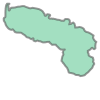

In [18]:
mainPolygon

In [19]:
WalkingDist = gpd.GeoDataFrame.from_dict([{'geometry':0,'Walkingtime':0},
                                          {'geometry':0,'Walkingtime':0}])

In [20]:
WalkingDist.Walkingtime[0]=15
WalkingDist.geometry[0]=mainPolygon
WalkingDist

,Walkingtime,geometry
0,15,POLYGON ((-73.89580509323054 40.68748438278429...
1,0,0


In [21]:
def pointinsidepoligon15(point):
    return point.within(WalkingDist.geometry[0])

In [22]:
affectedTracts['bigManhattanCommute'] = False

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
affectedTracts['BlockCentroid'] = affectedTracts['geometry'].centroid

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
affectedTracts['bigManhattanCommute'] =\
affectedTracts.BlockCentroid.map(pointinsidepoligon15)

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


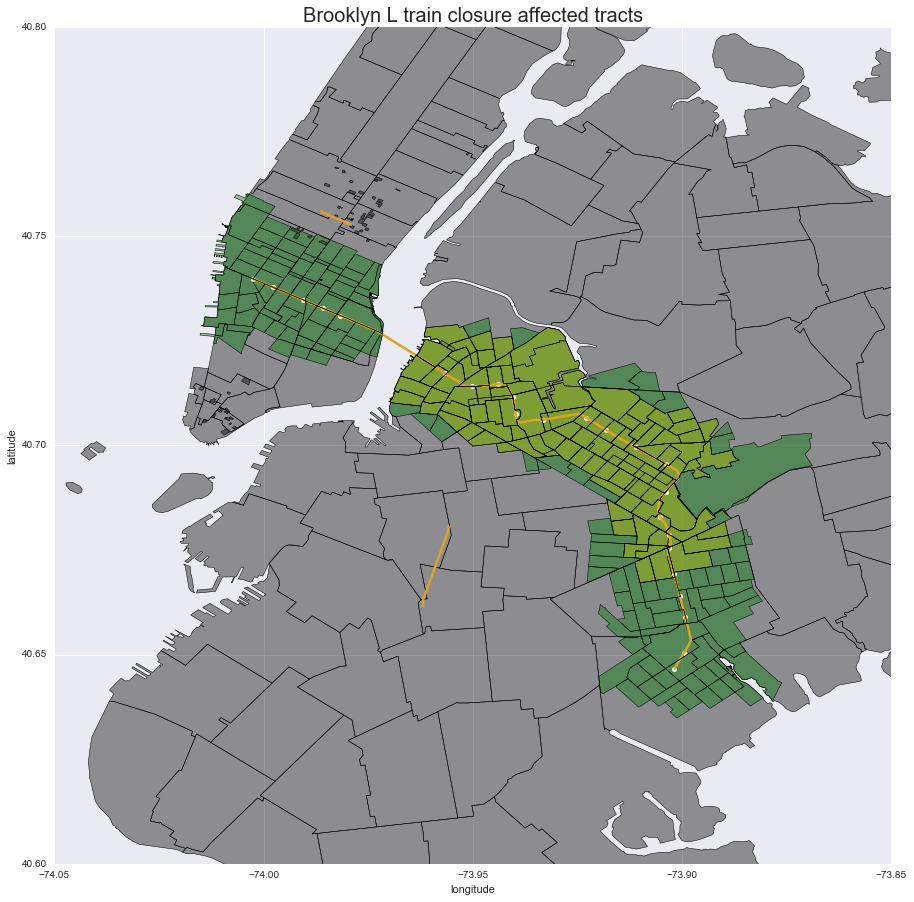

In [25]:
# Plot with the affected Tracts (Filtered by )

f, ax = pl.subplots(figsize=(15,15))

NYCshape.plot(linewidth = 0.5, color = 'k', ax = ax,alpha=.4)
lsubStations.plot(marker='o', markersize=5, linewidth = 4, color = 'w', ax = ax)
lsubline.plot(linewidth = 2.5, color = 'goldenrod' , ax = ax)
affectedTracts.plot(linewidth = 0.5, color = 'g', ax = ax, alpha=.4)
affectedTracts[affectedTracts.bigManhattanCommute == True].plot\
(linewidth = 0.5, color = 'y', ax = ax, alpha=.4)
pl.xlabel('longitude')
pl.ylabel('latitude')
pl.ylim(40.6, 40.8)
pl.xlim(-74.05, -73.85)
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
pl.title("Brooklyn L train closure affected tracts", size=20)

In [31]:
affectedTracts.iloc[:,:-1]

,Within15min,Within30min,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng,bigManhattanCommute
114,1,1,3,3028501,Brooklyn,I,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824,True
133,1,1,3,3036300,Brooklyn,E,036300,363,(POLYGON ((-73.91400482503951 40.6732394879431...,133,BK79,Ocean Hill,4007,2785736.31011,8445.46688322,False
134,1,1,3,3036502,Brooklyn,E,036502,365.02,(POLYGON ((-73.90267831840295 40.6757897287538...,134,BK79,Ocean Hill,4007,1252061.56461,6132.19606711,True
137,1,1,3,3039700,Brooklyn,E,039700,397,(POLYGON ((-73.91464246723457 40.6875070419845...,137,BK78,Bushwick South,4002,1712820.27346,6560.68169372,False
138,1,1,3,3039900,Brooklyn,E,039900,399,(POLYGON ((-73.92115385566102 40.6927966934759...,138,BK78,Bushwick South,4002,1627809.30279,6391.34887911,True
139,1,1,3,3040100,Brooklyn,E,040100,401,(POLYGON ((-73.9101894925993 40.68727090706882...,139,BK78,Bushwick South,4002,1718318.94334,5246.3001646,True
143,1,1,3,3041300,Brooklyn,E,041300,413,(POLYGON ((-73.90804254478043 40.6906470016253...,143,BK78,Bushwick South,4002,1745182.8807,5284.90236853,True
145,1,1,3,3041500,Brooklyn,E,041500,415,(POLYGON ((-73.91180565427025 40.6927850827546...,145,BK78,Bushwick South,4002,1750287.79067,5326.72460181,True
146,1,1,3,3041700,Brooklyn,E,041700,417,(POLYGON ((-73.91556201290929 40.6949221254473...,146,BK78,Bushwick South,4002,1519400.53544,5025.01524971,True
148,1,1,3,3041900,Brooklyn,E,041900,419,(POLYGON ((-73.91932072862139 40.6970603968718...,148,BK78,Bushwick South,4002,1646861.69945,5222.70054092,True


In [32]:
with open('Data/Reducedtrack.geojson', 'w') as f:
    f.write(affectedTracts.iloc[:,:-1].to_json())